In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [3]:
#! pip install jyquickhelper

# Imports<a class="anchor" id="chapter10"></a>

## Imports principaux <a class="anchor" id="chapter101"></a>

In [213]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pathlib
import os
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go
import warnings
from plotly.subplots import make_subplots
import json
import geopandas as gpd
from os.path import join

from collections import Counter
from tqdm import tqdm

#prétraitement (normalisation)
from sklearn import preprocessing

#ACP
from sklearn import decomposition
from sklearn import preprocessing


#Outils de distances pour calculer les inerties entre les Clusters
from sklearn import metrics
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import centroid

#Kmeans
from sklearn.cluster import KMeans

time_now = dt.datetime.now().strftime("%d_%m_%Y")

## Imports bases de données et infos carto <a class="anchor" id="chapter102"></a>

Dataset pour carto

In [214]:
path_main = 'C:\\Users\\DIAGNE\\Desktop\\ENSAE_3A\\EJE_POC_IE'

In [6]:
#path_main = 'C:\\Users\\Elise\\Desktop\\2625\\211126_EJE_POC_IE'

In [215]:
# Load datasets
#covid
path_dept = join(path_main,'Shapes_carto\\indicateur-suivi-covid19-departement-france.csv')
df00 = pd.read_csv(path_dept, sep=';')

#basetourisme
path = 'data_EJE\\'
file = 'Base-hébergement-tourisme_CC_-2021_maj'
try : 
    map_df = pd.read_csv(join(path_main, path + file+".csv"), low_memory=False)
except FileNotFoundError:
    map_df = pd.read_excel(join(path_main,path + file+".xlsm"), "COM")
    map_df.to_csv(join(path_main,path + file+".csv"), index=False)
print('{} successfully loaded'.format(file))
#base vieillissement pop
file = 'insee_rp_hist_1968.xlsx'
vp_df = pd.read_excel(join(path_main,path, file), 'Data')
vp_df = vp_df.rename(columns = {vp_df.columns[k] :vp_df.iloc[3,k] for k in range(len(vp_df.columns)) })
vp_df = vp_df.loc[4:,:]

print('{} successfully loaded'.format(file))


path = 'Shapes_carto\\'
file2 = "communes-20190101.json"

# Opening JSON file
f = open(os.path.join(path_main, path + file2))
communes = json.load(f)
gdf = gpd.GeoDataFrame.from_features(communes)
print('{} successfully loaded'.format(file2))


Base-hébergement-tourisme_CC_-2021_maj successfully loaded
insee_rp_hist_1968.xlsx successfully loaded
communes-20190101.json successfully loaded


In [235]:
# clc restricted to 2018
clc = pd.read_csv(join(path_main, 'clc_2018.csv'), sep =";")

C:\Users\DIAGNE\anaconda3\envs\geo_env\lib\site-packages\IPython\core\interactiveshell.py:3441: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [238]:
clc = clc[clc["ANNEE"]==2018]

In [218]:
#
dep_df = map_df

In [9]:
#clc.head()

## Settings

In [142]:
pd.set_option("display.max_columns",None) 
pd.set_option('display.max_colwidth', None) 

In [12]:
#dep = '06'
#dep = '22'
#dep = '29'

In [13]:
# dep_name = "Alpes Maritimes"
#dep_name = "Cotes-D'Armor"

Restrict dataframes to dep

In [219]:
vp_df = vp_df.rename(columns = {'codgeo' : 'CODGEO', 'libgeo': 'LIBGEO'})
vp_df['CODGEO'] = vp_df['CODGEO'].astype(str)
#vp_df = vp_df.loc[(vp_df['CODGEO'].str.startswith(dep)) & (vp_df['an'] == '2018' ),:]

In [220]:
#Sélection du département 
#dep_df = map_df.loc[map_df[map_df['DEP'] == dep].index, :]


# Tous les départements 
vp_df = vp_df.loc[(vp_df['an'] == '2018' ),:]

In [244]:
clc

,CODGEO,ANNEE,base,CLC_1,CLC_2,CLC_3,CLC_4,CLC_5
250292,1001,2018,CLC 2018,57.631793,1131.276099,376.566609,0.0,0.000000
250293,1002,2018,CLC 2018,0.000000,321.820765,591.172335,0.0,0.000000
250294,1004,2018,CLC 2018,870.920533,377.808737,1200.130679,0.0,0.000000
250295,1005,2018,CLC 2018,108.074041,1256.275286,55.269926,0.0,185.437198
250296,1006,2018,CLC 2018,33.099297,124.659585,444.888768,0.0,0.000000
...,...,...,...,...,...,...,...,...
286043,95676,2018,CLC 2018,0.001888,415.984175,423.348487,0.0,0.000000
286044,95678,2018,CLC 2018,76.655659,380.281627,530.241613,0.0,0.000000
286045,95680,2018,CLC 2018,366.831641,363.211159,0.000000,0.0,0.000000
286046,95682,2018,CLC 2018,29.644033,289.829967,0.000000,0.0,0.000000


In [240]:
clc = clc.rename(columns = {'NUM_COM' : 'CODGEO'})
clc['CODGEO'] = clc['CODGEO'].astype(str)

In [146]:
#clc = clc.loc[(clc['CODGEO'].str.startswith(dep)) & (clc['ANNEE'] == 2018 ),:]
#clc = clc.loc[(clc['ANNEE'] == 2018 ),:]

# Important functions

In [147]:
def make_table_quartile(column, df = dep_df, name = '', key = 'CODGEO', output_new_df = True) : 
    """[outputs a table dividing one column into quartiles]

    Args:
        column (str): [name of the column to quartile]
        df (DataFrame, optional): [DataFrame containing the column]. Defaults to dep_df.
        name (str, optional): [name of the output column containing the quartiles]. Defaults to ''.
        key (str, optional): [key of the dataframe ]. Defaults to 'CODGEO'.
        output_new_df (bool, optional): [if true the returns a new dataframe containing nly the key, long_key, 
                                            column and quartiles, if False adds the quartile column to the input 
                                            dataframe]. Defaults to True.

    Prints: 
        the bounds of each quartiles
    Returns:
        DataFrame: [DataFrame with the comumns]
        Array: [values of the quartiles]
    """
    try : 
        q_series, q_values = pd.qcut(df[column],  4, labels = range(4), retbins = True)
    except ValueError : 
        q_series, q_values = pd.qcut(df[column].rank(method = 'first'),  4, labels = range(4), retbins = True)
        
    print('The values of the quartiles are ', q_values)
    if name == '' : 
        name_quartile_column = column + '_quartile'
    else : 
        name_quartile_column = name
        
    if output_new_df : 
        temp = df.loc[:,[key,column]]
        temp[name_quartile_column] = q_series
        return temp, q_values
    else : 
        df[name_quartile_column] = q_series
        return df, q_values

# Main

In [148]:
tab = dep_df.loc[:,['CODGEO','LIBGEO']] #output table df
quartiles = pd.DataFrame({'indicateur' : [], 
                         'q0' : [],
                         'q1' : [],
                         'q2' : [],
                         'q3' : [],
                         'q4' : []
                         })

## Indicateurs structurels 

- Base-hébergement-tourisme_CC_-2021_maj (en csv et en xlsm)
    - Le nombre d’habitants (tableau et quartiles) 
    - Superficie de la commune (tableau et quartiles) 
    - Nombre de lits marchands de la commune (tableau et quartiles) et __cartographie communale__
    - Nombre de lits en résidence secondaire (tableau et quartiles) et __cartographie communale__
    - Part de résidences secondaires sur le total des logements (tableau et quartiles) et __cartographie communale__
    - Taux de fonction touristique (tableau et quartiles) et __cartographie communale.__
    - Le TCAM de la population sur les cinq dernières années (tableau et quartiles) 
- Base insee
    - L’indice de vieillissement (tableau et quartiles) 
- Base clc
    - Part de surfaces artificialisées de la commune (tableau et quartiles) 
    - Part d’espaces protégés (tableau et quartiles) 


### base hébergement

Création indicateurs : 


In [20]:
#part residence secondaire 

In [222]:
dep_df['P18_RSP'] = dep_df['P18_RSECOCC'] / (dep_df['P18_RSECOCC'] +dep_df['P18_RP'] )

In [22]:
#tcam

In [223]:
dep_df['TCAM'] = np.power(dep_df['POP18']/dep_df['P10_POP'],1/( 2018-2010)) - 1

In [224]:
# taux de fonction touristique
dep_df['tx_ft'] = (dep_df["Lits marchands 2018 (hors PtoP)"]+dep_df["P18_RSECOCC"]*5) / dep_df["POP18"]

In [225]:
# nombre de lits en résidences secondaire en 2018
dep_df['P18_LITRS'] = dep_df["P18_RSECOCC"] * 5 

indicateurs et quartiles

In [226]:
indicateurs_tab = ['tx_ft','POP18', 'SUPERF', 'Lits marchands 2021 inc. PtoP)',"Lits marchands 2018 (hors PtoP)",
                  'TCAM', 'P18_RSP', 'P18_LITRS']
indicateurs_map = ['tx_ft','Lits marchands 2021 inc. PtoP)', "Lits marchands 2018 (hors PtoP)", 'P18_RSP', 'P18_LITRS']

In [227]:
for indicator in indicateurs_tab : 
    tmp , qv = make_table_quartile(indicator)    
    tab = pd.merge(tab, tmp, on = 'CODGEO', how = 'left')    
    quartiles = pd.concat([quartiles, pd.DataFrame([[indicator] + list(qv)], columns = quartiles.columns)])    

The values of the quartiles are  [0.00000000e+00 7.01239400e-02 2.08807200e-01 6.24683651e-01
 1.78191399e+02]
The values of the quartiles are  [0.000000e+00 2.030000e+02 4.670000e+02 1.181000e+03 2.192485e+06]
The values of the quartiles are  [4.000e-02 6.480e+00 1.094e+01 1.892e+01 1.836e+04]
The values of the quartiles are  [0.00000e+00 2.00000e+00 2.00000e+01 8.60000e+01 3.77143e+05]
The values of the quartiles are  [1.00000e+00 8.73850e+03 1.74760e+04 2.62135e+04 3.49510e+04]
The values of the quartiles are  [-0.12206413 -0.00280599  0.00465324  0.01275523  0.21719567]
The values of the quartiles are  [0.         0.02917183 0.08163265 0.20161757 0.97349989]
The values of the quartiles are  [0.00000000e+00 3.51314415e+01 9.61789038e+01 2.55359431e+02
 6.42041492e+05]


In [50]:
#dep_df[['CODGEO', 'LIBGEO', 'Lits marchands 2021 inc. PtoP)']]

In [51]:
#dep_df[['CODGEO', 'LIBGEO', 'P18_LITRS']]

In [52]:
#dep_df[['CODGEO', 'LIBGEO', 'P18_RSP']]

In [53]:
#dep_df[['CODGEO', 'LIBGEO', 'tx_ft']]

### base insee

In [228]:
tmp , qv = make_table_quartile('ind_vieillist', df = vp_df)    
tab = pd.merge(tab, tmp, on = 'CODGEO', how = 'left')    
quartiles = pd.concat([quartiles, pd.DataFrame([['ind_vieillist'] + list(qv)], columns = quartiles.columns)])    

The values of the quartiles are  [   0.   66.   91.  132. 6800.]


In [229]:
indicateurs_tab.append('ind_vieillist')

### CLC 

In [234]:
clc[clc.isna()]

,CODGEO,ANNEE,base,CLC_1,CLC_2,CLC_3,CLC_4,CLC_5,SUPERF
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
35751,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35752,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35753,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [231]:
# on ajoute les variables de dep_df dans clc 
clc = pd.merge(clc, dep_df[['CODGEO', 'SUPERF']], on = 'CODGEO', how = 'left')

In [158]:
clc['SUPERF'] = clc['SUPERF'] * 100 #km2 to ha

In [159]:
clc['surf_artif'] = clc['CLC_1'] / clc['SUPERF']

In [160]:
clc['surf_protege'] = clc['SUPERF'] - (clc['CLC_1'] + clc['CLC_2'])

In [161]:
tmp , qv = make_table_quartile('surf_artif', df = clc)    
tab = pd.merge(tab, tmp, on = 'CODGEO', how = 'left')    
quartiles = pd.concat([quartiles, pd.DataFrame([['surf_artif'] + list(qv)], columns = quartiles.columns)])   

The values of the quartiles are  [1.0000e+00 7.9240e+03 1.5847e+04 2.3770e+04 3.1693e+04]


In [162]:
tmp , qv = make_table_quartile('surf_protege', df = clc)    
tab = pd.merge(tab, tmp, on = 'CODGEO', how = 'left')    
quartiles = pd.concat([quartiles, pd.DataFrame([['surf_protege'] + list(qv)], columns = quartiles.columns)])   

The values of the quartiles are  [ -620.66483706    48.42975907   196.68085074   556.40138034
 40575.32858694]


In [163]:
indicateurs_tab.append('surf_artif')
indicateurs_tab.append('surf_protege')

## évolution de l'offre

- __Evolution de la capacité d’accueil en lits__ (tableau et quartiles) 
- Densité de lits au km² (tableau et quartiles)
- Evolution des lits marchands (tableau et quartiles) 
- Evolution des résidences secondaires (tableau et quartiles) 

In [164]:
# Evolutions capacité en lit 
dep_df['evol_capa_lit'] = (dep_df['Lits marchands 2018 (hors PtoP)'] + dep_df["P18_RSECOCC"] * 5  ) 
dep_df['evol_capa_lit'] = dep_df['evol_capa_lit'] - (dep_df['Lits marchands 2015 (hors PtoP)'] + dep_df["P15_RSECOCC"] * 5 )

In [165]:
# Evolution des lits marchants
#2021 2015
dep_df['evol_lit_marchant'] = dep_df['Lits marchands 2021 (hors PtoP)'] - dep_df['Lits marchands 2015 (hors PtoP)']

In [166]:
#Evolution des résidences secondaires (tableau et quartiles)#
#2018 2015
dep_df['evol_rs'] = dep_df['P18_RSECOCC'] - dep_df['P15_RSECOCC']

In [167]:
# Densité de lits au km²
dep_df['denseite_lit_t'] = dep_df['Lits touristiques 2021 inc. PtoP']/dep_df['SUPERF']

In [168]:
ind_offre = ['evol_lit_marchant', 'evol_rs', 'denseite_lit_t' , 'evol_capa_lit']

In [169]:
for indicator in ind_offre : 
    tmp , qv = make_table_quartile(indicator)    
    tab = pd.merge(tab, tmp, on = 'CODGEO', how = 'left')    
    quartiles = pd.concat([quartiles, pd.DataFrame([[indicator] + list(qv)], columns = quartiles.columns)])    

The values of the quartiles are  [1.00000e+00 8.73850e+03 1.74760e+04 2.62135e+04 3.49510e+04]
The values of the quartiles are  [-6.76092505e+02 -1.56045721e+00  2.96296296e-01  2.70237914e+00
  1.57573015e+04]
The values of the quartiles are  [0.00000000e+00 5.22325309e+00 1.13475082e+01 2.51587105e+01
 1.69931915e+04]
The values of the quartiles are  [-7.35364383e+03 -9.56690152e+00  1.14454776e+00  1.35050371e+01
  8.76525073e+04]


In [170]:
indicateurs_tab = indicateurs_tab + ind_offre

## Concernant la dynamique de la demande

-	Saisonnalité des dépenses étrangères courbes (du département par rapport à la courbe de la moyenne des départements littoraux)
-	Dépenses étrangères Tableau et quartiles 
-	Evolution des dépenses étrangères Tableau et quartiles
-	Evolution des nuitées hôtelières tableau et quartiles
-   Prix de l'immobilier


#### Saisonnalité des dépenses étrangères courbes

In [172]:
ret = pd.read_csv(join(path_main, 'data_EJE', 'Résultats Atout France Retrait Toutes CR last.csv' ))
paie =  pd.read_csv(join(path_main, 'data_EJE', 'Résultats Atout France Paiement Toutes CR last.csv' ))

In [78]:
#path_main = "")
#ret = pd.read_csv('C:\\Users\\DIAGNE\\Desktop\\ENSAE_3A\\EJE_POC_IE\\data_EJE\\Résultats Atout France Retrait Toutes CR last.csv' )
#paie = pd.read_csv( 'C:\\Users\\DIAGNE\\Desktop\\ENSAE_3A\\EJE_POC_IE\\data_EJE\\Résultats Atout France Paiement Toutes CR last.csv')


In [ ]:
# Pour l'indicateur de saisonnalité à intégrer on considère le montant de dépense annuel moyen

In [95]:
#paie.head()

In [98]:
#test = paie[paie['Département'].isin(dep_littoraux)].groupby(['Année','Département'], as_index = False).mean()

In [173]:
test[test['Année']==2021]

In [82]:
dep_littoraux = [
"Nord",
"Pas-de-Calais",
"Somme",
"Seine-Maritime",
"Eure",
"Calvados",
"Manche",
"Ille-et-Vilaine",
"Cotes-D'Armor",
'Finistere',
'Morbihan',
'Loire-Atlantique',
'Vendee',
'Charente-Maritime',
'Gironde',
'Landes',
'Pyrenees-Atlantiques',
"Pyrenees-Orientales",
"Aude",
"Herault",
"Gard",
"Bouches-du-Rhone",
"Var",
"Alpes-Maritimes",
"Corse"]

In [83]:
paie_litt = paie[paie['Département'].isin(dep_littoraux)].groupby(['Année', 'Mois', 'Département'], as_index = False).sum().groupby(['Année', 'Mois'], as_index = False).mean().groupby('Mois', as_index = False).mean().drop(['Année', 'Nb Paiements'], axis = 1)

In [84]:
paie_litt.head()

,Mois,Montant Paiement
0,1.0,9.480941e+05
1,2.0,9.097125e+05
2,3.0,1.060910e+06
3,4.0,1.395988e+06
4,5.0,1.770064e+06


In [52]:
#paie_dep = paie[paie['Département'] == dep_name].groupby(['Année', 'Mois'], as_index = False).sum().groupby('Mois', as_index = False).mean().drop(['Année', 'Nb Paiements'], axis = 1)

C:\Users\DIAGNE\AppData\Local\Temp/ipykernel_7916/1884845393.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ylabels)


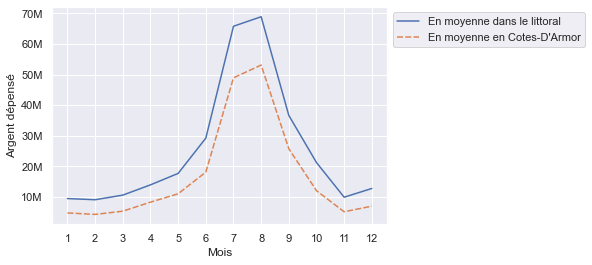

In [57]:
ax = sns.lineplot(data = paie_litt[['Montant Paiement_litt', 'Montant Paiement_dep']]
                 )
ax.set_xlabel("Mois")
ax.set_ylabel("Argent dépensé")
ylabels = ['{:,.0f}'.format(x) + 'M' for x in ax.get_yticks()/100000]
ax.set_yticklabels(ylabels)
plt.xticks(range(12), labels = range(1, 13))
plt.legend(labels=["En moyenne dans le littoral","En moyenne en {}".format(dep_name)], bbox_to_anchor = (1,1))
plt.show()


#### prix de l'immobilier 

In [174]:
immo = pd.read_csv(join(path_main, 'prixm2-loyer-communes-2019.csv'))

In [103]:
#immo.head(5)

In [175]:
immo = immo.rename(columns = {'INSEE_COM' : 'CODGEO'})

In [124]:
#immo = immo.loc[immo['INSEE_DEP'] == str(int(dep)),:]

In [176]:
immo['CODGEO'] = immo['CODGEO'].astype(str)
dep_df['CODGEO'] = dep_df['CODGEO'].astype(str)
tab['CODGEO'] = tab['CODGEO'].astype(str)

In [177]:
indicateur_immo = ['PrixMoyen_M2', 'loyer_apparts']

In [178]:
for indicator in indicateur_immo : 
    tmp , qv = make_table_quartile(indicator, immo)    
    tab = pd.merge(tab, tmp, on = 'CODGEO', how = 'left')    
    quartiles = pd.concat([quartiles, pd.DataFrame([[indicator] + list(qv)], columns = quartiles.columns)])    

The values of the quartiles are  [    0.     578.    1240.5   1748.75 14803.  ]
The values of the quartiles are  [ 0.          7.67810651  8.60729338  9.8263567  36.65443839]


### save 

In [179]:
tab.describe()

,tx_ft,POP18,SUPERF,Lits marchands 2021 inc. PtoP),Lits marchands 2018 (hors PtoP),TCAM,P18_RSP,P18_LITRS,surf_artif,surf_protege,evol_lit_marchant,evol_rs,denseite_lit_t,evol_capa_lit,PrixMoyen_M2,loyer_apparts
count,34945.000000,3.495100e+04,34950.000000,34951.000000,34951.000000,34944.000000,34942.000000,34951.000000,31693.000000,31693.000000,34951.000000,34950.000000,34950.000000,34950.000000,31694.000000,31694.000000
mean,0.725183,1.944818e+03,18.103974,259.346113,143.625275,0.005245,0.144650,502.688798,0.078253,529.108545,-3.191554,4.783496,48.432164,22.521802,1250.893008,9.009131
std,2.104956,1.521480e+04,147.470981,2538.846252,1309.342403,0.013962,0.163206,4589.206101,0.143119,1158.720927,162.048816,99.865220,293.383182,553.220275,998.417180,1.950258
min,0.000000,0.000000e+00,0.040000,0.000000,0.000000,-0.122064,0.000000,0.000000,0.000000,-620.664837,-7224.000000,-676.092505,0.000000,-7353.643828,0.000000,0.000000
25%,0.070124,2.030000e+02,6.480000,2.000000,0.000000,-0.002806,0.029172,35.131442,0.000000,48.429759,0.000000,-1.560457,5.223253,-9.566902,571.000000,7.669686
50%,0.208807,4.670000e+02,10.940000,20.000000,0.000000,0.004653,0.081633,96.178904,0.032270,196.680851,0.000000,0.296296,11.347508,1.144548,1240.500000,8.591317
75%,0.624684,1.181000e+03,18.920000,86.000000,10.000000,0.012755,0.201618,255.359431,0.081806,556.401380,0.000000,2.702379,25.158710,13.505037,1748.000000,9.878471
max,178.191399,2.192485e+06,18360.000000,377143.000000,183664.000000,0.217196,0.973500,642041.491503,1.386459,40575.328587,16461.000000,15757.301470,16993.191489,87652.507349,14803.000000,29.982547


In [180]:
path_ALL = "C:\\Users\\DIAGNE\\Desktop\\ENSAE_3A\\EJE_POC_IE\\EJE_POC_IE-main\\ALL_dep\\"
tab.to_csv(join(path_ALL,'indicateurs_ALL_dep.csv'))
#quartiles.to_csv(join(path_main, dep, 'quartiles_indicateurs_{}.csv'.format(dep)))

In [58]:
#tab.to_csv('indicateurs_29.csv')
#quartiles.to_csv('quartiles_indicateurs_29.csv')

In [201]:
# si on considère les 10 départements 

 
dep10 = ('06','17','22','29','33','34','35','44','57','83')
tab10 = tab.loc[tab['CODGEO'].str.startswith(dep10),]

In [212]:
tab10[tab10['CODGEO'].str.startswith('06')][['CODGEO','surf_artif']]

,CODGEO,surf_artif
1870,06001,NaN
1871,06002,NaN
1872,06003,NaN
1873,06004,NaN
1874,06005,NaN
...,...,...
2028,06159,NaN
2029,06160,NaN
2030,06161,NaN
2031,06162,NaN


In [203]:
tab10[tab10.isna()]

,CODGEO,LIBGEO,tx_ft,tx_ft_quartile,POP18,POP18_quartile,SUPERF,SUPERF_quartile,Lits marchands 2021 inc. PtoP),Lits marchands 2021 inc. PtoP)_quartile,Lits marchands 2018 (hors PtoP),Lits marchands 2018 (hors PtoP)_quartile,TCAM,TCAM_quartile,P18_RSP,P18_RSP_quartile,P18_LITRS,P18_LITRS_quartile,ind_vieillist,ind_vieillist_quartile,surf_artif,surf_artif_quartile,surf_protege,surf_protege_quartile,evol_lit_marchant,evol_lit_marchant_quartile,evol_rs,evol_rs_quartile,denseite_lit_t,denseite_lit_t_quartile,evol_capa_lit,evol_capa_lit_quartile,PrixMoyen_M2,PrixMoyen_M2_quartile,loyer_apparts,loyer_apparts_quartile
1870,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1871,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1873,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1874,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32432,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Clustering

In [191]:
#map_df = tab[indicateurs_map + ['CODGEO', 'LIBGEO']]

ind = ['tx_ft', 'POP18','SUPERF','Lits marchands 2021 inc. PtoP)','Lits marchands 2018 (hors PtoP)','TCAM',
       'P18_RSP','P18_LITRS','ind_vieillist','surf_artif','surf_protege','evol_lit_marchant','evol_rs',
       'denseite_lit_t','evol_capa_lit','PrixMoyen_M2','loyer_apparts']

In [190]:
#tab[ind]

In [192]:
from sklearn.preprocessing import MinMaxScaler

dataset = tab[ind].copy()
object= MinMaxScaler()
    
# standardization 
data_scaled = object.fit_transform(dataset) 
 
data_scaled= pd.DataFrame(data_scaled,columns=ind)

In [194]:
#data_scaled

In [195]:
# Function Elbow viz

def apply_kmeans_elbow(X, kmin = 1, kmax=10):
    kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(X)
                for k in range(kmin, kmax)]
    inertias = [model.inertia_ for model in kmeans_per_k]
    plt.figure(figsize=(8, 3.5))
    plt.plot(range(kmin, kmax), inertias, "bo-")
    plt.xlabel("$k$", fontsize=14)
    plt.ylabel("Inertia", fontsize=14)
    # plt.axis([1, 8.5, 0, 1300])
    # save_fig("inertia_vs_k_diagram")
    plt.show()


# Dendrogram function

def train_plot_dendrogram(X, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    model = AgglomerativeClustering(n_clusters=None ,distance_threshold=0, affinity='euclidean', linkage='ward', compute_distances = True)
    model.fit(X)
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
    
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')


In [196]:
X = data_scaled

In [197]:
apply_kmeans_elbow(X)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
train_plot_dendrogram(X)

In [ ]:
k=
ac = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward', compute_distances = True)
y = ac.fit_predict(X)